# Helical Quick Start Tutorial

Run this notebook on a colab notebook with a free GPU:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/helicalAI/helical/blob/main/examples/notebooks/Quick-Start-Tutorial.ipynb)

This quick-start tutotial is meant to get you up and runninng quickly on Helical. If it is the first time you use helical, you can execute all cells sequentially (if you are already familiar with most concepts, you can jump to the most relevant section).

Please check out our other example notebooks on our [github](https://github.com/helicalAI/helical) in the `example` folder or in our [documentation](https://helical.readthedocs.io/) to explore actual applications of bio foundation models.

## Installation/Update of the Helical package
If you have never worked with helical, or if you want to have the latest version of Helical, be sure to run the cell below before getting started

In [ ]:
# !pip install helical

## Installation of the data set used in our example notebooks
We first load the human fetal yolk sac scRNA-seq data from the Helical Hugging Face datasets.

In [ ]:
import logging
import warnings
from datasets import load_dataset

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

dataset = load_dataset("helical-ai/yolksac_human", split="train[:10%]", trust_remote_code=True, download_mode="reuse_cache_if_exists")
labels = dataset["LVL1"]

In [7]:
from helical.utils import get_anndata_from_hf_dataset

ann_data = get_anndata_from_hf_dataset(dataset)
ann_data

AnnData object with n_obs × n_vars = 2534 × 37318
    obs: 'size', 'LVL1', 'LVL2', 'LVL3'
    var: 'gene_name'

Unamiliar with anndata ? anndata is a Python package for handling annotated data matrices in memory and on disk, positioned between pandas and xarray. You can find thei docuemntation [here](https://anndata.readthedocs.io/).

## Select the model you want to work with
As of now, Helical allows you to work with the main RNA models. Over time new models trained on DNA, RNA and proteins will be added. The models are also outline in our [doc]().

To query our models, you can use run the cell below:

In [11]:
from helical import models
import pkgutil
for model in pkgutil.iter_modules(models.__path__):
    if model.name != "base_models" and model.name != "fine_tune":
        print("Model :",model.name)

Model : classification
Model : geneformer
Model : hyena_dna
Model : scgpt
Model : uce


## Import and download the model of your choice
We made it really easy for you here. The first time you want to work with a new model, by simply calling it, Helical will automatically download the model weights and all supporting files that you will require.

In the example below, we want to work with Geneformer:

In [ ]:
from helical.models.geneformer import Geneformer, GeneformerConfig
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_config = GeneformerConfig(batch_size=10,device=device)
geneformer = Geneformer(configurer=model_config)

In [ ]:
#from helical.models.uce.model import UCE,UCEConfig

#model_config=UCEConfig(batch_size=10)
#uce = UCE(configurer=model_config)

## Process the data
Preprocessing your data can be complicated, especially when working with different models and benchmarking them. Our `process_data` function takes care of this for each model automatically.

In [ ]:
dataset = geneformer.process_data(ann_data[:100], gene_names="gene_name")

## Generate Embeddings
Let the magic happen!
Use the `get_embeddings()` function of each model to use to infere the embedding of each data point. These embeddings contain all the information encoded by the foundation model and can later be used in diverse use cases suach as cell type annotations.

In [18]:
embeddings = geneformer.get_embeddings(dataset)

print(embeddings.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

(100, 512)


## Plot/visualize the embeddings
Finally, you can visualize these embeddings by using dimensionality reduction techniques such as UMAP.

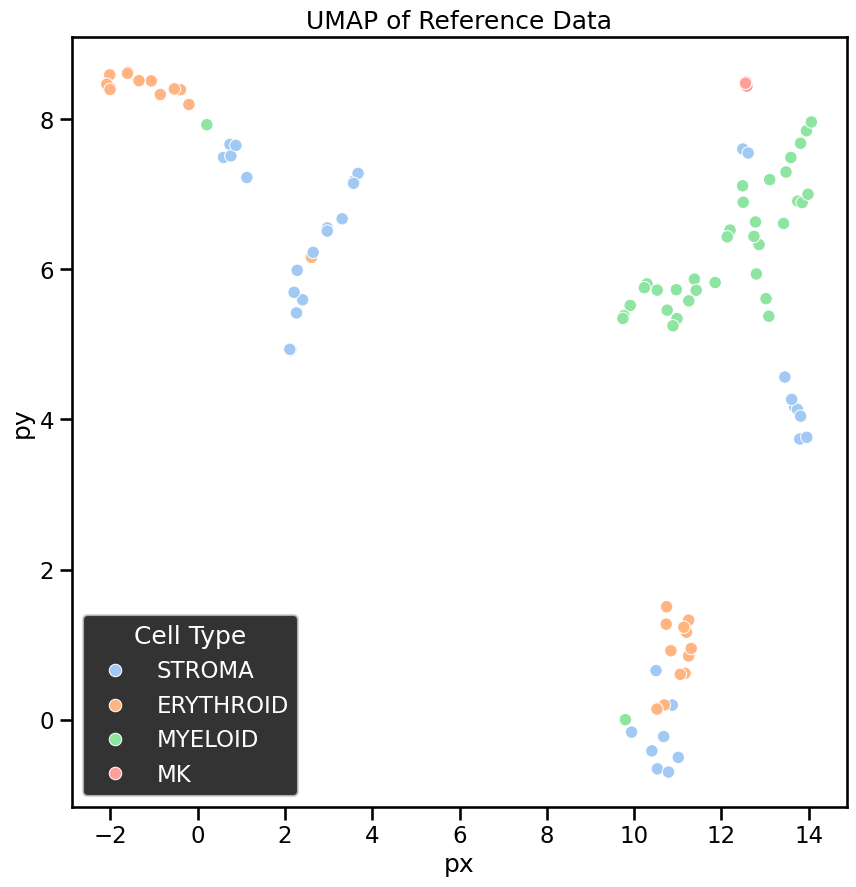

In [20]:
import umap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



reducer = umap.UMAP(min_dist=0.1, n_components=2, n_epochs=None,n_neighbors=4)
mapper = reducer.fit(embeddings)

labels = labels[:100]

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
plot_df['Cell Type'] = labels

plt.figure(figsize=(10,10))
ax = plt.axes()
sns.set_style('dark')
plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=ax,palette="pastel")
plt.title('UMAP of Reference Data')
plt.show()